In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from flax.serialization import from_bytes
import os
import sys
import jax
import jax.numpy as jnp
import time
import tensorflow as tf
import tensorflow_datasets as tfds  # TFDS to download MNIST.
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Moves one directory up
sys.path.append(project_root)

from src.model import Milo, CNN
from src.train import create_state_MLP
from src.utils import preprocess

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"]
    })

device = jax.devices("cpu")[0] #Currently CPU
rng = jax.random.PRNGKey(0)

In [3]:
milo = Milo(
    input_dim=(28, 28), 
    hidden_layer_dim=[(64, 64), (36, 36), (18, 16), (10, 1)],
    output_dim=(10, 1)
)

simpleCNN = CNN()

milo_state_template = create_state_MLP(rng, milo, 0, data_size=(32, 28, 28), device=device)
cnn_state_template = create_state_MLP(rng, simpleCNN, 0, data_size=(32, 28, 28, 1), device=device)

with open("D:\Toolkit\Backup\Personal Projects\milo_net\models\milo_best_state.msgpack", "rb") as f:
    milo_best_state = from_bytes(milo_state_template, f.read())

with open("D:\Toolkit\Backup\Personal Projects\milo_net\models\cnn_best_state.msgpack", "rb") as f:
    cnn_best_state = from_bytes(cnn_state_template, f.read())

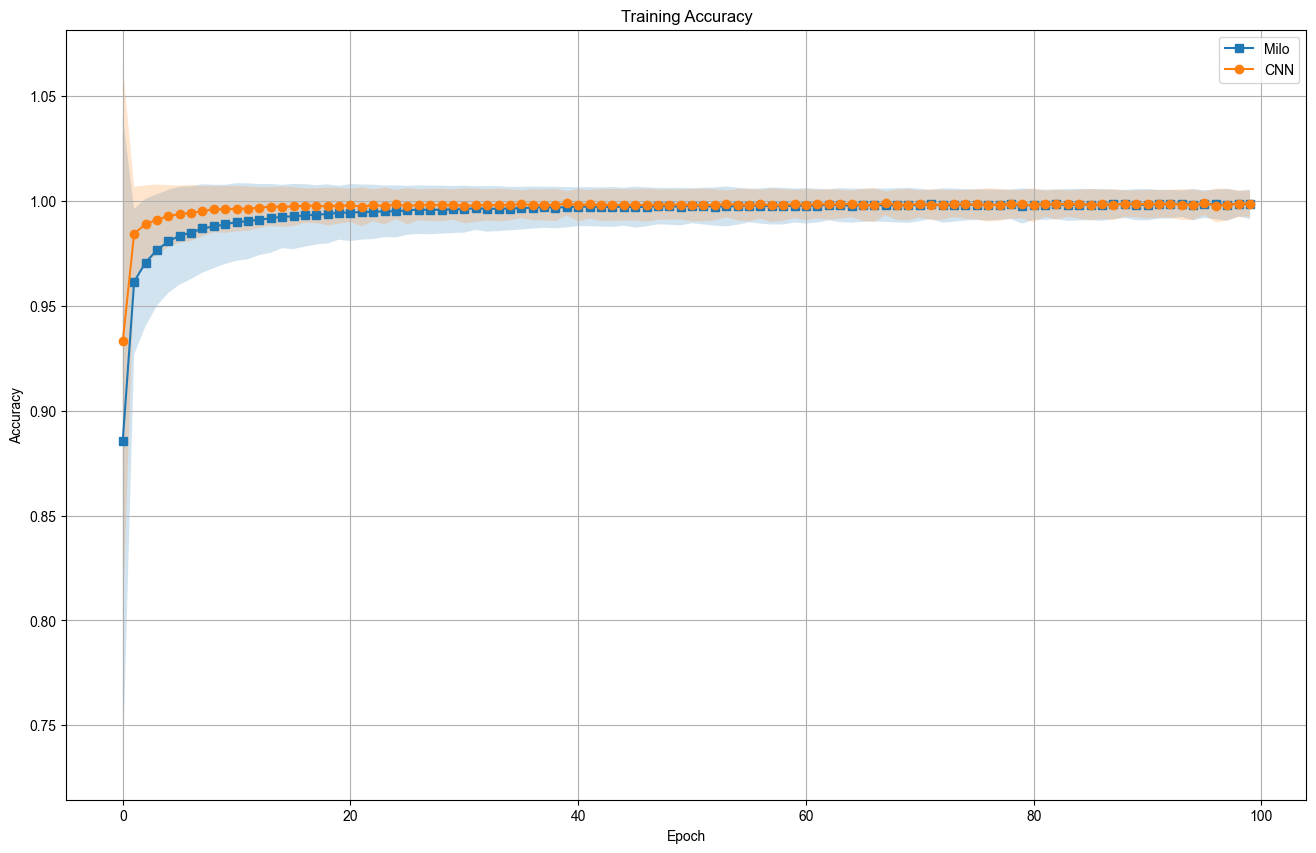

Highest Milo accuracy: 0.9988
Highest CNN accuracy: 0.9990


In [4]:
# --- Load metrics ---
with open("D:\Toolkit\Backup\Personal Projects\milo_net\models\mnist_metrics_history.json", "r") as f:
    metrics = json.load(f)

# --- Accuracy Plot ---
plt.figure(figsize=(16, 10))
plt.plot(metrics['milo_accuracy'], label='Milo', marker = "s")
plt.fill_between(range(len(metrics['milo_accuracy'])),
                 np.array(metrics['milo_accuracy']) - np.array(metrics['milo_accuracy_std']),
                 np.array(metrics['milo_accuracy']) + np.array(metrics['milo_accuracy_std']),
                 alpha=0.2)
plt.plot(metrics['cnn_accuracy'], label='CNN', marker = "o")
plt.fill_between(range(len(metrics['cnn_accuracy'])),
                 np.array(metrics['cnn_accuracy']) - np.array(metrics['cnn_accuracy_std']),
                 np.array(metrics['cnn_accuracy']) + np.array(metrics['cnn_accuracy_std']),
                 alpha=0.2)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

max_milo_accuracy = np.max(metrics['milo_accuracy'])
max_cnn_accuracy = np.max(metrics['cnn_accuracy'])

# Print results
print(f"Highest Milo accuracy: {max_milo_accuracy:.4f}")
print(f"Highest CNN accuracy: {max_cnn_accuracy:.4f}")

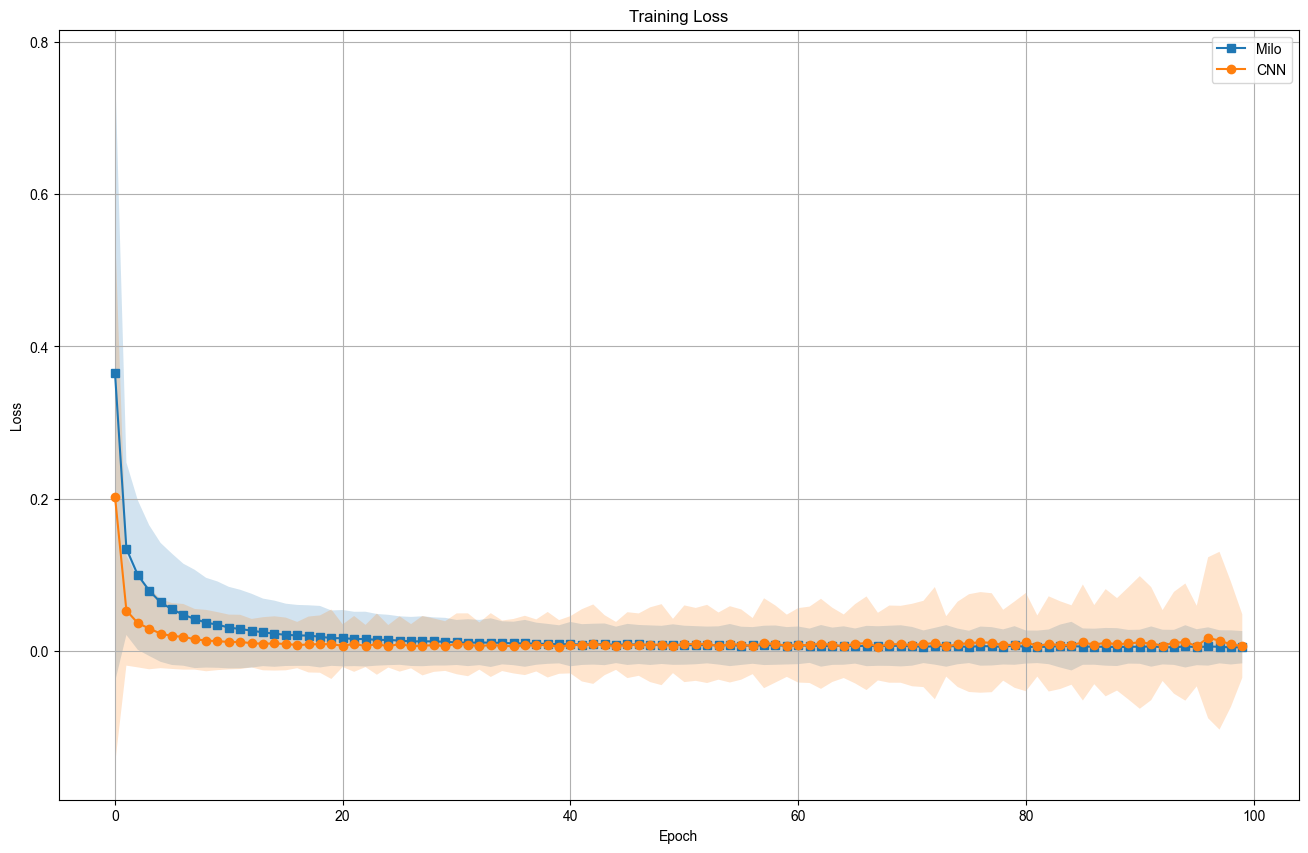

Lowest Milo loss: 0.0044
Lowest CNN loss: 0.0051


In [5]:
plt.figure(figsize=(16, 10))
plt.plot(metrics['milo_loss'], label='Milo', marker = "s")
plt.fill_between(range(len(metrics['milo_loss'])),
                 np.array(metrics['milo_loss']) - np.array(metrics['milo_loss_std']),
                 np.array(metrics['milo_loss']) + np.array(metrics['milo_loss_std']),
                 alpha=0.2)
plt.plot(metrics['cnn_loss'], label='CNN', marker = "o")
plt.fill_between(range(len(metrics['cnn_loss'])),
                 np.array(metrics['cnn_loss']) - np.array(metrics['cnn_loss_std']),
                 np.array(metrics['cnn_loss']) + np.array(metrics['cnn_loss_std']),
                 alpha=0.2)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

min_milo_loss = np.min(metrics['milo_loss'])
min_cnn_loss = np.min(metrics['cnn_loss'])

# Print results
print(f"Lowest Milo loss: {min_milo_loss:.4f}")
print(f"Lowest CNN loss: {min_cnn_loss:.4f}")

In [6]:
total_milo_time = sum(metrics['milo_time'])
total_milo_std = np.sqrt(sum(np.array(metrics['milo_time_std'])**2))

total_cnn_time = sum(metrics['cnn_time'])
total_cnn_std = np.sqrt(sum(np.array(metrics['cnn_time_std'])**2))

print(f"Total Milo training time: {total_milo_time:.2f} ± {total_milo_std:.2f} seconds")
print(f"Total CNN training time: {total_cnn_time:.2f} ± {total_cnn_std:.2f} seconds")

Total Milo training time: 1.09 ± 0.05 seconds
Total CNN training time: 3.93 ± 0.10 seconds


In [21]:
from jax.flatten_util import ravel_pytree

# --- Parameter count ---
def count_params(params):
    flat_params, _ = ravel_pytree(params)
    return flat_params.shape[0]

print(f"Milo params: {count_params(milo_best_state.params):,}")
print(f"CNN params:  {count_params(cnn_best_state.params):,}")

print(f"Parameter suppression (CNN → Milo): {count_params(cnn_best_state.params) - count_params(milo_best_state.params):,} fewer parameters ({(1 - count_params(milo_best_state.params) / count_params(cnn_best_state.params)) * 100:.2f}% reduction)")

Milo params: 30,715
CNN params:  225,418
Parameter suppression (CNN → Milo): 194,703 fewer parameters (86.37% reduction)


In [8]:
milo_size_mb = os.path.getsize("D:\Toolkit\Backup\Personal Projects\milo_net\models\milo_best_state.msgpack") / (1024**2)
cnn_size_mb = os.path.getsize("D:\Toolkit\Backup\Personal Projects\milo_net\models\cnn_best_state.msgpack") / (1024**2)

print(f"Milo model size: {milo_size_mb:.2f} MB")
print(f"CNN model size:  {cnn_size_mb:.2f} MB")

Milo model size: 0.35 MB
CNN model size:  2.58 MB


In [9]:
test_ds, info = tfds.load('mnist', split='test', with_info=True)
test_ds = test_ds.map(preprocess).batch(32, drop_remainder=True).prefetch(1)

In [10]:
def benchmark_inference(apply_fn, params, image_batch, label_batch, calc_flops=True, model_type = "CNN"):
    if model_type == "CNN":
        image_batch = jnp.array(image_batch)
    else:
        image_batch = jnp.array(tf.squeeze(image_batch))
        
    label_batch = jnp.array(label_batch)
    variables = {'params': params}

    # Warm-up
    apply_fn(variables, image_batch)
    jax.block_until_ready(apply_fn(variables, image_batch))

    # Measure inference time
    start = time.time()
    logits = apply_fn(variables, image_batch)
    jax.block_until_ready(logits)
    end = time.time()

    # Compute accuracy
    predictions = jnp.argmax(logits.squeeze(), axis=-1)
    accuracy = jnp.mean(predictions == label_batch)

    # Optional: Calculate FLOPs
    flops = None
    if calc_flops:
        # Use jax.xla_computation to trace the computation and estimate FLOPs

        comp = jax.jit(apply_fn).lower(variables, image_batch).compile()
        flops = comp.cost_analysis()['flops']  # Might need jaxlib >= 0.4.10+
    
    # Return results
    return {
        "time_per_image": (end - start) / len(image_batch),
        "accuracy": float(accuracy),
        "flops": flops
    }

def summarize(metrics_list, name):
    times = [m['time_per_image'] for m in metrics_list]
    accs = [m['accuracy'] for m in metrics_list]
    flops = [m['flops'] for m in metrics_list if m['flops'] is not None]

    print(f"{name} average inference time: {np.mean(times) * 1e3:.3f} ms/image ± {np.std(times) * 1e3:.3f} ms")
    print(f"{name} accuracy: {np.mean(accs) * 100:.2f}%")

    if flops:
        print(f"{name} average FLOPs: {np.mean(flops) / 1e6:.2f} MFLOPs")
    print()

In [11]:
cnn_metrics = []
milo_metrics = []

for batch in test_ds:
    images, labels = batch

    milo_metrics.append(benchmark_inference(milo_best_state.apply_fn, milo_best_state.params, images, labels, model_type="MILO"))
    cnn_metrics.append(benchmark_inference(cnn_best_state.apply_fn, cnn_best_state.params, images, labels, model_type = "CNN"))

# Print summary
summarize(cnn_metrics, "CNN")
summarize(milo_metrics, "Milo")

CNN average inference time: 0.902 ms/image ± 0.239 ms
CNN accuracy: 99.15%
CNN average FLOPs: 606.63 MFLOPs

Milo average inference time: 0.795 ms/image ± 0.245 ms
Milo accuracy: 98.33%
Milo average FLOPs: 55.93 MFLOPs



In [18]:
def get_predictions(best_state, test_ds, remove_channel=True):
    apply_fn = best_state.apply_fn
    params = best_state.params

    all_preds = []
    all_labels = []

    # Handle both tf.data.Dataset and tuple inputs
    if isinstance(test_ds, tf.data.Dataset):
        ds_iter = test_ds.as_numpy_iterator()
    else:
        images, labels = test_ds
        ds_iter = [(images, labels)]

    for image_batch, label_batch in ds_iter:
        # Optionally remove channel dimension for grayscale
        if remove_channel:
            image_batch = tf.squeeze(image_batch, axis=-1)

        # Convert to JAX arrays
        image_batch = jnp.array(image_batch)
        label_batch = jnp.array(label_batch)

        variables = {'params': params}

        # Run inference
        logits = apply_fn(variables, image_batch)
        preds = jnp.argmax(logits.squeeze(), axis=-1)

        all_preds.append(preds)
        all_labels.append(label_batch)

    # Concatenate all results
    preds = jnp.concatenate(all_preds, axis=0)
    labels = jnp.concatenate(all_labels, axis=0)

    return preds, labels


def plot_cm(ax, cm, title):
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
    ax.set_title(title)
    tick_marks = np.arange(10)
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    # Cell labels
    for i in range(10):
        for j in range(10):
            val = cm[i, j]
            ax.text(j, i, f"{val:.2f}",
                    ha="center", va="center",
                    color="white" if val > 0.5 else "black")

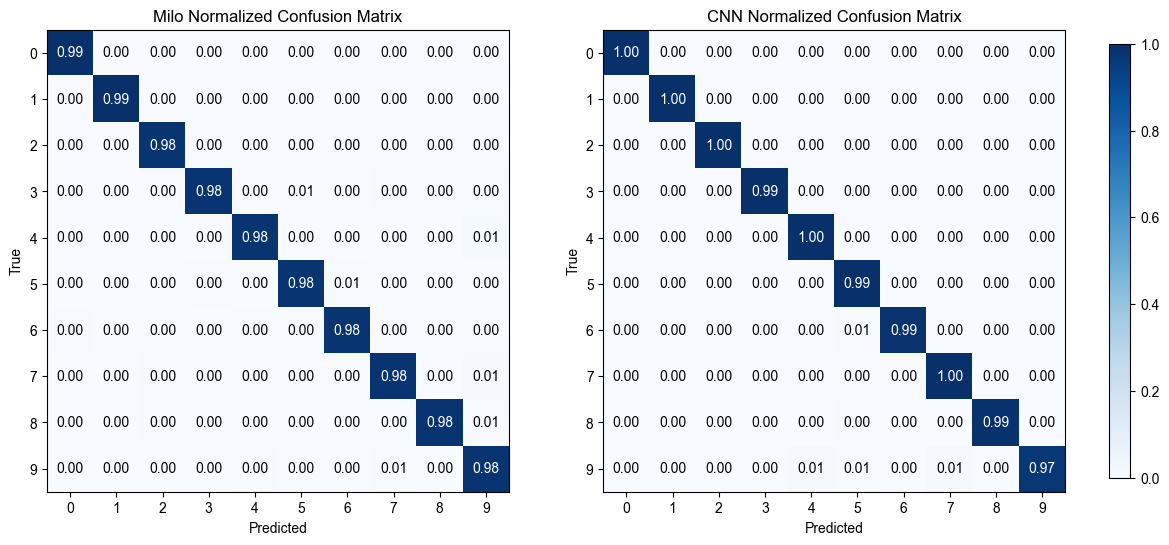

In [20]:
# Get predictions
milo_preds, milo_labels = get_predictions(milo_best_state, test_ds, remove_channel=True)
cnn_preds, cnn_labels   = get_predictions(cnn_best_state, test_ds, remove_channel=False)

# Compute normalized confusion matrices
def normalize_cm(cm):
    return cm.astype('float') / cm.sum(axis=1, keepdims=True)

milo_cm = normalize_cm(confusion_matrix(milo_labels, milo_preds))
cnn_cm  = normalize_cm(confusion_matrix(cnn_labels, cnn_preds))

# --- Plot side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot both confusion matrices
plot_cm(axes[0], milo_cm, "Milo Normalized Confusion Matrix")
plot_cm(axes[1], cnn_cm, "CNN Normalized Confusion Matrix")

# Add colorbar
fig.colorbar(axes[0].images[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()